In [1]:
import pyspark.sql.types as T 
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
%matplotlib inline  

In [2]:
businessDF_raw = spark.read.json("business.json")
reviewDF_raw =  spark.read.json("review.json")
userDF_raw =  spark.read.json("user.json")

In [3]:
businessDF_raw.createOrReplaceTempView("business_raw")
reviewDF_raw.createOrReplaceTempView("review_raw")
userDF_raw.createOrReplaceTempView("user_raw")

In [4]:
businessDF = spark.sql("""
SELECT business_id as bus_id, name, city, state, stars as bus_stars, review_count as ResReview_count, is_open, attributes,categories, hours  FROM business_raw
""")
reviewDF = spark.sql("""SELECT review_id, user_id as u_id, business_id,stars as rev_stars,date FROM review_raw
""")
userDF = spark.sql("""
SELECT user_id, name, review_count as UserReview_count, yelping_since, friends, average_stars from user_raw """)

In [5]:
businessDF.createOrReplaceTempView("business")
reviewDF.createOrReplaceTempView("review")
userDF.createOrReplaceTempView("user")

In [6]:
combineDF = spark.sql(""" SELECT * FROM review
INNER JOIN   business  ON business.bus_id = review.business_id
INNER JOIN  user ON user.user_id = review.u_id
""")

In [7]:
combineDF.createOrReplaceTempView("combine")

# spark.sql("""
# SELECT * FROM combine
# LIMIT 5
# """).toPandas()

In [8]:
#combineDF.describe().toPandas()

In [9]:
# spark.sql("""
# select city, count(business_id) FROM combine
# group by city
# order by count(business_id) DESC
# """).toPandas()

In [10]:
citycombineDF = spark.sql("""
SELECT * FROM combine
WHERE categories like 'Restau%' and ( city like 'Toron%' or city like 'Markha%' or city like 'Mississau%' 
or city like 'North York%' or city like 'Richmond Hil%')""")


In [11]:
# citycombine2 = citycombineDF.toPandas()
# citycombine2.to_csv("city combine.csv")  


In [12]:
citycombineDF.createOrReplaceTempView("citycombine")

In [13]:
citycombineDF.describe().toPandas()

,summary,review_id,u_id,business_id,rev_stars,date,bus_id,name,city,state,bus_stars,ResReview_count,is_open,categories,user_id,name,UserReview_count,yelping_since,friends,average_stars
0,count,45047,45047,45047,45047,45047,45047,45047,45047,45047,45047,45047,45047,45047,45047,45047,45047,45047,45047,45047
1,mean,None,None,None,3.575132639243457,None,None,229.0,None,None,3.5510799831287323,144.92982884542812,0.8021621861611206,None,None,None,228.0255732901192,None,None,3.61555020312118
2,stddev,None,None,None,1.1609140880508113,None,None,0.0,None,None,0.5437292106250926,145.88746014511867,0.39837361392986176,None,None,None,600.038936018167,None,None,0.4732182279202408
3,min,--0zXw3_ZjcRXPo3CRBKQw,--7gjElmOrthETJ8XqzMBw,-AVRReI-nfsa0lKlehEojw,1.0,2008-08-06 23:04:28,-AVRReI-nfsa0lKlehEojw,180 Secondi,Markham,BC,1.0,3,0,Restaurants,--7gjElmOrthETJ8XqzMBw,.,1,2005-03-04 04:26:12,"--Qh8yKWAvIP4V4K8ZPfHA, oGjHvq_gGA1liPultrPwOw...",1.0
4,max,zzd6yae3FNXoXHOjQrDn_A,zzo--VpSQh8PpsGVeMC1dQ,zxWbNs31PLO0DKBTY4L4Ig,5.0,2018-11-14 17:43:19,zxWbNs31PLO0DKBTY4L4Ig,z-teca Gourmet Burritos,Toronto,ON,5.0,700,1,"Restaurants, Women's Clothing, Cuban, Fashion,...",zzo--VpSQh8PpsGVeMC1dQ,Ôdré,7750,2018-09-30 12:30:23,"zzltQbbtriSWWdNINMzJUw, jfgdYDS1h5Io4zfAxsoKfQ...",5.0


In [14]:
#user EDA
spark.sql("""
SELECT COUNT(DISTINCT review_id) ReviewCount, COUNT(DISTINCT business_id) BusinessCount, COUNT(DISTINCT user_id) UserCount FROM citycombine
""").toPandas()

,ReviewCount,BusinessCount,UserCount
0,45047,1798,12039


In [15]:
userProfileDF=spark.sql("""
SELECT u_id, COUNT (review_id) reviews, AVG (rev_stars) average_stars FROM citycombine
GROUP BY u_id
""")

In [16]:
userProfileDF.createOrReplaceTempView("userProfile")

In [17]:
userProfileDF.describe().toPandas()

,summary,u_id,reviews,average_stars
0,count,12039,12039,12039
1,mean,None,3.7417559597973256,3.619805013285821
2,stddev,None,6.408895572208613,1.083251985229071
3,min,--7gjElmOrthETJ8XqzMBw,1,1.0
4,max,zzo--VpSQh8PpsGVeMC1dQ,336,5.0


In [27]:
review5DF = spark.sql("""
SELECT u_id, reviews FROM userProfile WHERE reviews>=5""")

In [28]:
review5DF.createOrReplaceTempView("review5")
review5DF.describe().toPandas()

,summary,u_id,reviews
0,count,2609,2609
1,mean,None,11.021080873898045
2,stddev,None,10.889641623587044
3,min,--BumyUHiO_7YsHurb9Hkw,5
4,max,zzo--VpSQh8PpsGVeMC1dQ,336


In [29]:
review10DF = spark.sql("""
SELECT u_id, reviews FROM userProfile WHERE reviews>=10""")
review10DF.createOrReplaceTempView("review10")
review10DF.describe().toPandas()

,summary,u_id,reviews
0,count,982,982
1,mean,None,18.5040733197556
2,stddev,None,14.90381953064924
3,min,--Qh8yKWAvIP4V4K8ZPfHA,10
4,max,zsna_iioQVRKVNn3NLUjMA,336


In [30]:
dataReview5DF = spark.sql("""
Select * FROM citycombine INNER JOIN review5 WHERE citycombine.u_id = review5.u_id""")
dataReview5DF.createOrReplaceTempView("dataReview5")
dataReview5DF.describe().toPandas()

,summary,review_id,u_id,business_id,rev_stars,date,bus_id,name,city,state,...,is_open,categories,user_id,name,UserReview_count,yelping_since,friends,average_stars,u_id,reviews
0,count,28754,28754,28754,28754,28754,28754,28754,28754,28754,...,28754,28754,28754,28754,28754,28754,28754,28754,28754,28754
1,mean,None,None,None,3.547854211587953,None,None,229.0,None,None,...,0.7948111567086319,None,None,None,314.09779508937885,None,None,3.613027752660501,None,21.77672671628295
2,stddev,None,None,None,1.073429220104116,None,None,0.0,None,None,...,0.40384657217570213,None,None,None,708.8150158096455,None,None,0.34130885305038494,None,37.56314920121201
3,min,--0zXw3_ZjcRXPo3CRBKQw,--BumyUHiO_7YsHurb9Hkw,-AVRReI-nfsa0lKlehEojw,1.0,2008-08-07 20:37:47,-AVRReI-nfsa0lKlehEojw,180 Secondi,Markham,BC,...,0,Restaurants,--BumyUHiO_7YsHurb9Hkw,A,10,2005-09-21 16:54:53,"--kMIFSRj9a1e3C8it-XPQ, AePAOn3UQUM4th9cmzg-_w...",1.6,--BumyUHiO_7YsHurb9Hkw,5
4,max,zzd6yae3FNXoXHOjQrDn_A,zzo--VpSQh8PpsGVeMC1dQ,zxWbNs31PLO0DKBTY4L4Ig,5.0,2018-11-14 17:43:19,zxWbNs31PLO0DKBTY4L4Ig,z-teca Gourmet Burritos,Toronto,ON,...,1,"Restaurants, Women's Clothing, Cuban, Fashion,...",zzo--VpSQh8PpsGVeMC1dQ,waeza,6314,2018-08-10 14:22:07,"zxyGz4hPOjh06pa1OTAdlA, deRK6jNTvAHxiyh8iH1Uaw...",4.86,zzo--VpSQh8PpsGVeMC1dQ,336


In [31]:
dataReview10DF = spark.sql("""
Select * FROM citycombine INNER JOIN review10 WHERE citycombine.u_id = review10.u_id""")
dataReview10DF.createOrReplaceTempView("dataReview10")
dataReview10DF.describe().toPandas()

,summary,review_id,u_id,business_id,rev_stars,date,bus_id,name,city,state,...,is_open,categories,user_id,name,UserReview_count,yelping_since,friends,average_stars,u_id,reviews
0,count,18171,18171,18171,18171,18171,18171,18171,18171,18171,...,18171,18171,18171,18171,18171,18171,18171,18171,18171,18171
1,mean,None,None,None,3.5194540751747287,None,None,229.0,None,None,...,0.7842716416267679,None,None,None,438.18782675692034,None,None,3.595667822354301,None,30.49590006053602
2,stddev,None,None,None,1.0358428669120727,None,None,0.0,None,None,...,0.4113379939285248,None,None,None,858.5496720969315,None,None,0.3083125885000693,None,45.00043566385727
3,min,--0zXw3_ZjcRXPo3CRBKQw,--Qh8yKWAvIP4V4K8ZPfHA,-AVRReI-nfsa0lKlehEojw,1.0,2008-08-10 15:46:10,-AVRReI-nfsa0lKlehEojw,180 Secondi,Markham,BC,...,0,Restaurants,--Qh8yKWAvIP4V4K8ZPfHA,A,35,2006-06-13 20:23:03,"-4M7gBkHdKasC_sTQ4RhGQ, vzw1ZryOiTYGzl8N1yILtw...",2.12,--Qh8yKWAvIP4V4K8ZPfHA,10
4,max,zzd6yae3FNXoXHOjQrDn_A,zsna_iioQVRKVNn3NLUjMA,zvtkeghW0Px5HY9QkJ4INw,5.0,2018-11-14 17:43:19,zvtkeghW0Px5HY9QkJ4INw,z-teca Gourmet Burritos,Toronto,ON,...,1,"Restaurants, Women's Clothing, Cuban, Fashion,...",zsna_iioQVRKVNn3NLUjMA,sylvia,6314,2018-03-01 17:56:58,"zwmThlRiY1LHfJ_7zNfGqg, 0_iROv6FL4KCveV916IpTA...",4.83,zsna_iioQVRKVNn3NLUjMA,336


In [32]:
# dataReview5 = dataReview5DF.toPandas()
# dataReview5.to_csv("dataReview5.csv")

# dataReview10 = dataReview10DF.toPandas()
# dataReview10.to_csv("dataReview10.csv")

In [33]:
review20DF = spark.sql("""
SELECT * FROM userProfile WHERE reviews>=20""")
review20DF.createOrReplaceTempView("review20")
review20DF.describe().toPandas()

,summary,u_id,reviews,average_stars
0,count,263,263,263
1,mean,None,32.8212927756654,3.4802754408923517
2,stddev,None,23.02509423942855,0.3370224725192046
3,min,--Qh8yKWAvIP4V4K8ZPfHA,20,2.1
4,max,zsna_iioQVRKVNn3NLUjMA,336,4.428571428571429


In [34]:
dataReview20DF = spark.sql("""
Select * FROM citycombine INNER JOIN review20 WHERE citycombine.u_id = review20.u_id""")
dataReview20DF.createOrReplaceTempView("dataReview20")
dataReview20DF.describe().toPandas()

,summary,review_id,u_id,business_id,rev_stars,date,bus_id,name,city,state,...,categories,user_id,name,UserReview_count,yelping_since,friends,average_stars,u_id,reviews,average_stars
0,count,8632,8632,8632,8632,8632,8632,8632,8632,8632,...,8632,8632,8632,8632,8632,8632,8632,8632,8632,8632
1,mean,None,None,None,3.4640871177015757,None,None,229.0,None,None,...,None,None,None,725.5940685820204,None,None,3.561624189063948,None,48.91265060240964,3.464087117701575
2,stddev,None,None,None,0.9942988338864482,None,None,0.0,None,None,...,None,None,None,1171.9014431361334,None,None,0.2680228438026517,None,60.067372419259236,0.3218669954383225
3,min,-0HhZbPBlB1YZx3BhAfaEA,--Qh8yKWAvIP4V4K8ZPfHA,-AVRReI-nfsa0lKlehEojw,1.0,2008-08-10 15:46:10,-AVRReI-nfsa0lKlehEojw,180 Secondi,Markham,BC,...,Restaurants,--Qh8yKWAvIP4V4K8ZPfHA,Ada,87,2006-06-13 20:23:03,"-YYe0kff9YAYzr5L09TT_A, z7P_7ly4x4uIjvKCCm5ltw...",2.44,--Qh8yKWAvIP4V4K8ZPfHA,20,2.1
4,max,zzZq5kQUHHx4lF7gTFIqhw,zsna_iioQVRKVNn3NLUjMA,zvtkeghW0Px5HY9QkJ4INw,5.0,2018-11-14 17:43:19,zvtkeghW0Px5HY9QkJ4INw,z-teca Gourmet Burritos,Toronto,ON,...,"Restaurants, Women's Clothing, Cuban, Fashion,...",zsna_iioQVRKVNn3NLUjMA,Yvonne,6314,2017-04-15 23:24:08,"zo2vscKNvDzXWj7YOrdJVA, TPiHSV85VEkQ4m3gtp9hNw...",4.35,zsna_iioQVRKVNn3NLUjMA,336,4.428571428571429


In [35]:
# dataReview20 = dataReview20DF.toPandas()
# dataReview20.to_csv("dataReview20.csv")

In [ ]:
spark.sql("""
SELECT reviews, COUNT (u_id) users FROM review20
GROUP BY reviews
ORDER BY reviews
""").toPandas().plot(kind="bar", x="reviews", y="users", figsize=(10,5), color="blue", title="User Review Counts")

In [ ]:
spark.sql("""
SELECT CEIL(average_stars) average_stars, count(1) users FROM review20
GROUP BY CEIL(average_stars)
ORDER BY average_stars
""").toPandas().plot(kind="bar", x="average_stars", y="users", figsize=(10,5), color="blue", title="User Average Stars")

In [ ]:
businessProfileDF = spark.sql("""
SELECT business_id, COUNT(review_id) reviews, AVG(rev_stars) average_stars FROM dataReview20
GROUP BY business_id
""")

In [46]:
businessProfileDF.createOrReplaceTempView("busProfile")

In [47]:
businessProfileDF.describe().toPandas()

,summary,business_id,reviews,average_stars
0,count,1395,1395,1395
1,mean,None,6.187813620071685,3.3136996606674223
2,stddev,None,7.915387953232172,0.7801273098600799
3,min,-AVRReI-nfsa0lKlehEojw,1,1.0
4,max,zvtkeghW0Px5HY9QkJ4INw,68,5.0


common
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

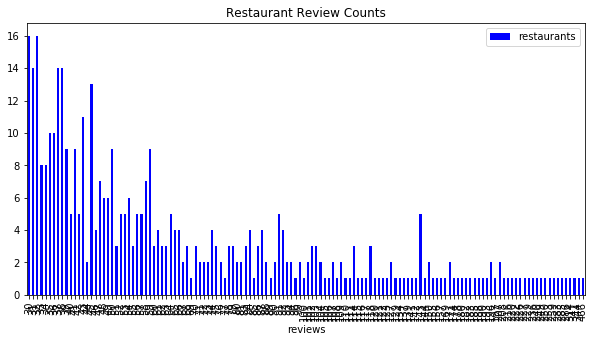

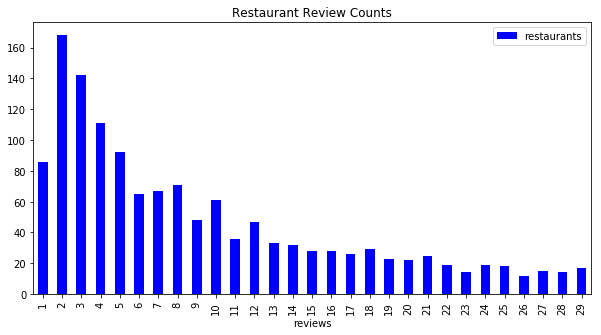

In [23]:
spark.sql("""
SELECT (reviews < 30) common, CEIL(reviews) reviews, count(1) restaurants FROM busProfile
GROUP BY (reviews < 30), CEIL(reviews)
ORDER BY common, reviews
""").toPandas().groupby("common").plot(kind="bar", x="reviews", y="restaurants", figsize=(10,5), color="blue", title="Restaurant Review Counts")

In [24]:
spark.sql("""
SELECT city, COUNT(DISTINCT business_id) count FROM citycombine
GROUP BY city
""").toPandas()

,city,count
0,Richmond Hill,82
1,Toronto,1270
2,Markham,126
3,Mississauga,258
4,North York,62


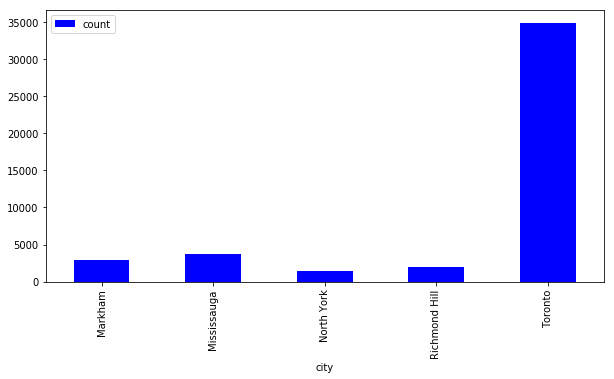

In [25]:
spark.sql("""
SELECT COUNT(business_id) count, city FROM citycombine
GROUP BY city
ORDER BY city
""").toPandas().plot(kind="bar", x="city", y="count", figsize=(10,5), color="blue")

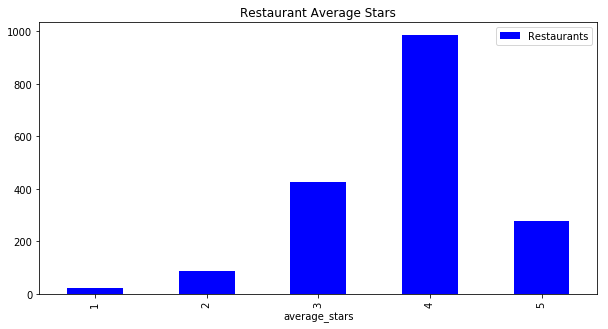

In [26]:
spark.sql("""
SELECT CEIL(average_stars) average_stars, count(1) Restaurants FROM busProfile
GROUP BY CEIL(average_stars)
ORDER BY average_stars
""").toPandas().plot(kind="bar", x="average_stars", y="Restaurants", figsize=(10,5), color="blue", title="Restaurant Average Stars")

In [27]:
reviewProfileDF = spark.sql("""SELECT review_id, business_id, user_id, rev_stars, date
From citycombine""")

In [28]:
reviewProfileDF.createOrReplaceTempView("reviewProfile")

In [29]:
reviewProfileDF.describe().toPandas()

,summary,review_id,business_id,user_id,rev_stars,date
0,count,45047,45047,45047,45047,45047
1,mean,None,None,None,3.575132639243457,None
2,stddev,None,None,None,1.1609140880508115,None
3,min,--0zXw3_ZjcRXPo3CRBKQw,-AVRReI-nfsa0lKlehEojw,--7gjElmOrthETJ8XqzMBw,1.0,2008-08-06 23:04:28
4,max,zzd6yae3FNXoXHOjQrDn_A,zxWbNs31PLO0DKBTY4L4Ig,zzo--VpSQh8PpsGVeMC1dQ,5.0,2018-11-14 17:43:19


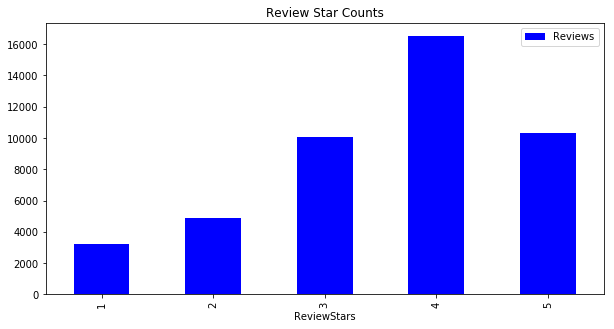

In [30]:
spark.sql("""
SELECT CEIL(rev_stars) ReviewStars, count(1) Reviews FROM reviewProfile
GROUP BY CEIL(rev_stars)
ORDER BY CEIL(rev_stars)
""").toPandas().plot(kind="bar", x="ReviewStars", y="Reviews", figsize=(10,5), color="blue", title="Review Star Counts")